### 1. ROI Head Rough Flow

ROI Head做的事情

a. 先把要忽略的ground truth忽略掉, 沒有要忽略就填None
``` python
if self.with_bbox or self.with_mask:
    num_imgs = len(img_metas)
    if gt_bboxes_ignore is None:
        gt_bboxes_ignore = [None for _ in range(num_imgs)]
```
再來做sampling，for每張照片
``` python
    sampling_results = []
    neg_label_weights = []
    for i in range(num_imgs):
```
**b. Assign ground truth box給 各prediction box**
``` python  
        assign_result = self.bbox_assigner.assign(
            proposal_list[i], gt_bboxes[i], gt_bboxes_ignore[i],
            gt_labels[i])
```
**c. Sample 一些positive, negative**
``` python
        sampling_result = self.bbox_sampler.sample(
            assign_result,
            proposal_list[i],
            gt_bboxes[i],
            gt_labels[i],
            feats=[lvl_feat[i][None] for lvl_feat in x])
```
最後將sampling結果列出，供後續
``` python
        # neg label weight is obtained by sampling when using ISR-N
        neg_label_weight = None
        if isinstance(sampling_result, tuple):
            sampling_result, neg_label_weight = sampling_result
        sampling_results.append(sampling_result)
        neg_label_weights.append(neg_label_weight)
```

In [1]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from mmdet.core.bbox.iou_calculators.builder import build_iou_calculator
from mmdet.core.bbox.assigners import AssignResult

In [2]:
image=torch.zeros((128,128,3))

bbox = torch.tensor([[20, 20, 100, 100],],dtype=torch.int16) 
bbox_gt = torch.tensor([[60, 60, 100, 100],],dtype=torch.int16) 

In [3]:
iou_calculator=build_iou_calculator({'type':'BboxOverlaps2D'})
def add_bbox(img,box,color,text):
    img=cv2.rectangle(img, box[:2].numpy(),box[2:].numpy(), color=color, thickness=1)
    plt.text(*box[:2].numpy(),
             text,
             color=color,
             fontsize ="large",
             verticalalignment="bottom")
def show_box_and_iou(image,bbox_pred,bbox_gt):
    # 轉換圖片成numpy格式
    plt.figure(figsize=(5,5))
    img=image.detach().cpu().numpy().copy()
    color_pred=(1,1,1)
    color_gt=(0,1,0)
    for n,box in enumerate(bbox_pred):
        add_bbox(img,box,color_pred,f"{n}")
    for n,box in enumerate(bbox_gt):
        add_bbox(img,box,color_gt,f"gt{n}")
    plt.imshow(img)
    overlaps =iou_calculator(bbox_gt.to(torch.float32),bbox_pred.to(torch.float32))
    plt.show()
    return overlaps

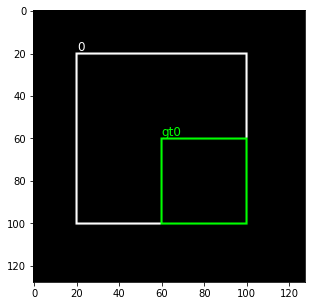

tensor([[0.2500]])

In [4]:
overlaps = show_box_and_iou(image,bbox,bbox_gt);overlaps

可以感受一下不同prediction,ground truth組合的的iou

In [5]:
# def rnd_bbox(frame_w=128,fram_h=128,amnt=6):
#     x=torch.randint(5,frame_w-5,(amnt*2,))
#     y=torch.randint(5,fram_h-5,(amnt*2,))
#     xs=torch.stack((x[:amnt],x[amnt:]),-1)
#     ys=torch.stack((y[:amnt],y[amnt:]),-1)
#     x_mins=xs.min(dim=-1,keepdim=True).values
#     y_mins=ys.min(dim=-1,keepdim=True).values
#     x_maxs=xs.max(dim=-1,keepdim=True).values
#     y_maxs=ys.max(dim=-1,keepdim=True).values
#     boxes=torch.cat((x_mins,y_mins,x_maxs,y_maxs),dim=-1)
#     return boxes
# W=128
# image=torch.zeros((W,W,3))
# num_gts=3;num_bboxes=2
# bbox=rnd_bbox(W,W,num_bboxes)
# bbox_gt = rnd_bbox(W,W,num_gts)
# overlaps = show_box_and_iou(image,bbox,bbox_gt);overlaps

為方便解說我們用固定的組合

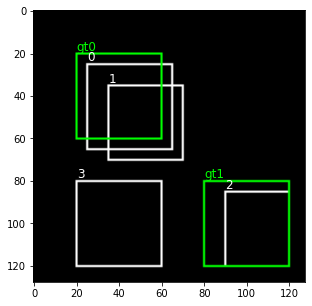

tensor([[0.6203, 0.2841, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6562, 0.0000]])

In [6]:
bbox = torch.tensor([[25, 25, 65, 65],
                        [35, 35, 70, 70],
                        [90, 85, 120, 120],
                        [20, 80, 60, 120]],dtype=torch.int16)
bbox_gt = torch.tensor([[20, 20, 60, 60],
                     [80, 80, 120, 120]],dtype=torch.int16) 
num_bboxes=len(bbox);num_gts=len(bbox_gt)
overlaps = show_box_and_iou(image,bbox,bbox_gt);overlaps

### Ground Truth Assignment

In [7]:
# 1. assign -1 by default
assigned_gt_inds = overlaps.new_full((num_bboxes, ),-1,dtype=torch.long)
assigned_gt_inds

tensor([-1, -1, -1, -1])

In [8]:
# for each anchor, which gt best overlaps with it
# for each anchor, the max iou of all gts
max_overlaps, argmax_overlaps = overlaps.max(dim=0)
print(max_overlaps, argmax_overlaps )
# for each gt, which anchor best overlaps with it
# for each gt, the max iou of all proposals
gt_max_overlaps, gt_argmax_overlaps = overlaps.max(dim=1)
print(gt_max_overlaps, gt_argmax_overlaps )

tensor([0.6203, 0.2841, 0.6562, 0.0000]) tensor([0, 0, 1, 0])
tensor([0.6203, 0.6562]) tensor([0, 2])


In [9]:
neg_iou_thr=0.3
# 2. assign negative: below the negative inds are set to be 0
if isinstance(neg_iou_thr, float):
    assigned_gt_inds[(max_overlaps >= 0)
                     & (max_overlaps < neg_iou_thr)] = 0
elif isinstance(neg_iou_thr, tuple):
    assert len(neg_iou_thr) == 2
    assigned_gt_inds[(max_overlaps >= neg_iou_thr[0])
                     & (max_overlaps < neg_iou_thr[1])] = 0
assigned_gt_inds

tensor([-1,  0, -1,  0])

In [10]:
pos_iou_thr=0.6
# 3. assign positive: above positive IoU threshold
pos_inds = max_overlaps >= pos_iou_thr
assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds] + 1
assigned_gt_inds

tensor([1, 0, 2, 0])

In [11]:
# Low-quality matching will overwrite the assigned_gt_inds assigned
# in Step 3. Thus, the assigned gt might not be the best one for
# prediction.
# For example, if bbox A has 0.9 and 0.8 iou with GT bbox 1 & 2,
# bbox 1 will be assigned as the best target for bbox A in step 3.
# However, if GT bbox 2's gt_argmax_overlaps = A, bbox A's
# assigned_gt_inds will be overwritten to be bbox B.
# This might be the reason that it is not used in ROI Heads.
min_pos_iou=0.3
gt_max_assign_all=True # by default
for i in range(num_gts):
    if gt_max_overlaps[i] >= min_pos_iou:
        if gt_max_assign_all:
            max_iou_inds = overlaps[i, :] == gt_max_overlaps[i]
            assigned_gt_inds[max_iou_inds] = i + 1
        else:
            assigned_gt_inds[gt_argmax_overlaps[i]] = i + 1
assigned_gt_inds

tensor([1, 0, 2, 0])

In [12]:
gt_labels=torch.tensor([0,1],dtype=torch.long) 
if gt_labels is not None:
    assigned_labels = assigned_gt_inds.new_full((num_bboxes, ), -1)
    pos_inds = torch.nonzero(
        assigned_gt_inds > 0, as_tuple=False).squeeze()
    if pos_inds.numel() > 0:
        assigned_labels[pos_inds] = gt_labels[
            assigned_gt_inds[pos_inds] - 1]
else:
    assigned_labels = None
assigned_labels

tensor([ 0, -1,  1, -1])

In [13]:
rslt=AssignResult(num_gts, assigned_gt_inds, max_overlaps, labels=assigned_labels)
rslt.info

{'num_gts': 2,
 'num_preds': 4,
 'gt_inds': tensor([1, 0, 2, 0]),
 'max_overlaps': tensor([0.6203, 0.2841, 0.6562, 0.0000]),
 'labels': tensor([ 0, -1,  1, -1])}

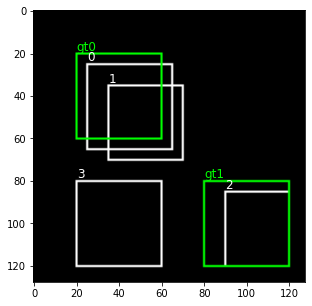

tensor([[0.6203, 0.2841, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6562, 0.0000]])

In [14]:
overlaps = show_box_and_iou(image,bbox,bbox_gt);overlaps

Importance-based Sample Reweighting(ISR)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def rank_score(rank,n_max=5):
    return (n_max-rank)/n_max
def sharpen(p,bet=0.,gam=1.):
    return ((1.-bet)*p+bet)**gam

<img src=https://i.imgur.com/65FacPS.png width="300">

In [33]:
hl_rank=np.array([0,1,2,3,4])
hlr_score=rank_score(hl_rank,n_max=4);print(hlr_score)
hlr_attention=sharpen(hlr_score,bet=0.5,gam=3);print(hlr_attention)

[1.   0.75 0.5  0.25 0.  ]
[1.         0.66992188 0.421875   0.24414062 0.125     ]


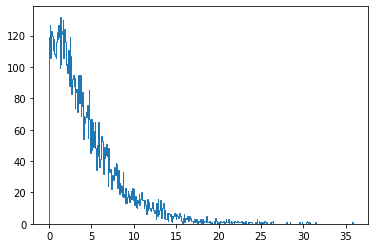

In [31]:
p=np.random.normal(loc=2.,size=(10000))
plt.hist(sharpen(p,bet=0.5,gam=3),bins=500,histtype="step")
plt.show()